<a href="https://colab.research.google.com/github/monicadesAI-tech/Project_69/blob/main/Image_3D_Parameterized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

assert tf.test.is_gpu_available()

# **3D Style Transfer**

This notebook uses Lucid to implement style transfer from a textured 3D model and
 a style image onto a new texture for the 3D model by using a Differentiable Image Parameterization.

 This notebook uses Lucid to produce feature visualizations on 3D mesh surfaces by using a Differentiable Image Parameterization.

 [link text](https://storage.googleapis.com/tensorflow-lucid/notebooks/styletransfer-3d/header.jpg) =724x

 Note: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup.

This notebook uses OpenGL and thus requires a GPU, unlikely most of our notebooks. 
You can check whether your GPU is available and configured correctly for tensorflow.

If the above assert statement fails, you can always run the notebook on colab and use a free GPU by selecting:

Runtime   →   Change runtime type   →   Hardware Accelerator: GPU

In [2]:
!pip install -q lucid>=0.2.3

In [3]:
!pip install tensorflow==1.15  #because lucid doesnot work with tensorflow2.x

Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
ERROR: tensorflow-probability 0.11.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0


In [4]:
!pip install --user --upgrade tensorflow-probability

Requirement already up-to-date: tensorflow-probability in /root/.local/lib/python3.6/site-packages (0.11.1)
  Using cached https://files.pythonhosted.org/packages/b6/48/583c032b79ae5b3daa02225a675aeb673e58d2cb698e78510feceb11958c/gast-0.4.0-py3-none-any.whl
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.4.0 which is incompatible.


In [5]:
# Importing Libraries
import os
import io
import sys
from string import Template
from pathlib import Path

import tensorflow.compat.v1.gfile

import numpy as np
import PIL.Image
import matplotlib.pylab as pl
from google.colab import files

from IPython.display import clear_output, display, Image, HTML

from lucid.misc.gl.glcontext import create_opengl_context
import OpenGL.GL as gl

from lucid.misc.gl import meshutil
from lucid.misc.gl import glrenderer
import lucid.misc.io.showing as show
import lucid.misc.io as lucid_io
from lucid.misc.tfutil import create_session

from lucid.modelzoo import vision_models
from lucid.optvis import objectives
from lucid.optvis import param
from lucid.optvis.style import StyleLoss, mean_l1_loss
from lucid.optvis.param.spatial import sample_bilinear

In [6]:
# You can check the installed version of OpenGL:
create_opengl_context()
gl.glGetString(gl.GL_VERSION)

b'4.6.0 NVIDIA 418.67'

In [7]:
model = vision_models.InceptionV1()
model.load_graphdef()

In [8]:
# Loading 3D model
# Let's download four 3D models.

In [9]:
TEXTURE_SIZE = 1024

In [10]:
!gsutil cp gs://deepdream/article_models.zip . && \
 unzip -qo article_models.zip && \
 ls -al article_models && \
 cat article_models/readme.txt

Copying gs://deepdream/article_models.zip...
/ [1 files][ 12.8 MiB/ 12.8 MiB]                                                
Operation completed over 1 objects/12.8 MiB.                                     
total 35580
drwxr-xr-x 2 root root     4096 May  4  2018 .
drwxr-xr-x 1 root root     4096 Oct 22 22:28 ..
-rw-r--r-- 1 root root      187 May  4  2018 bunny.mtl
-rw-r--r-- 1 root root  4409184 May  4  2018 bunny.obj
-rw-r--r-- 1 root root  1659808 Jan 23  2018 bunny.png
-rw-r--r-- 1 root root  1769962 Mar 15  2018 david.jpg
-rw-r--r-- 1 root root      187 May  4  2018 david.mtl
-rw-r--r-- 1 root root  9576385 May  4  2018 david.obj
-rw-r--r-- 1 root root   481003 Mar 15  2018 horse.jpg
-rw-r--r-- 1 root root      187 May  4  2018 horse.mtl
-rw-r--r-- 1 root root 15575138 May  4  2018 horse.obj
-rw-r--r-- 1 root root      299 May  4  2018 readme.txt
-rw-r--r-- 1 root root   795384 Mar 12  2018 skull.jpg
-rw-r--r-- 1 root root      187 May  4  2018 skull.mtl
-rw-r--r-- 1 root root  

In [11]:
def prepare_image(fn, size=None):
  data = lucid_io.reading.read(fn)
  im = PIL.Image.open(io.BytesIO(data)).convert('RGB')
  if size:
    im = im.resize(size, PIL.Image.ANTIALIAS)
  return np.float32(im)/255.0

In [12]:
mesh = meshutil.load_obj('article_models/bunny.obj')
mesh = meshutil.normalize_mesh(mesh)

original_texture = prepare_image('article_models/bunny.png', (TEXTURE_SIZE, TEXTURE_SIZE))


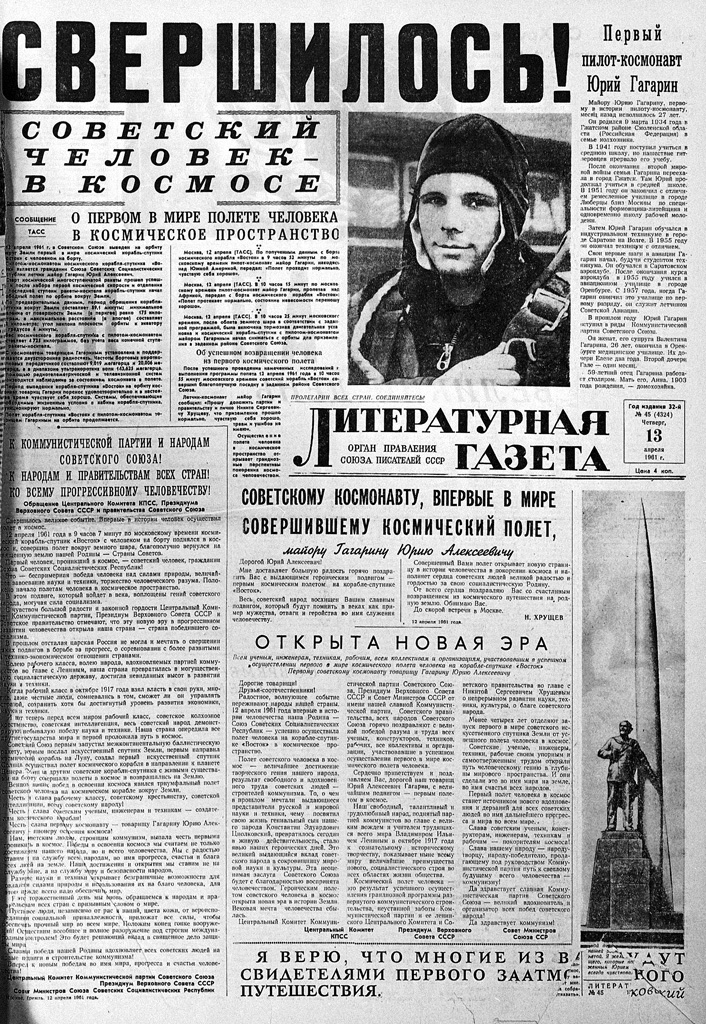

In [13]:
style_url = 'https://upload.wikimedia.org/wikipedia/commons/d/db/RIAN_archive_409362_Literaturnaya_Gazeta_article_about_YuriGagarin%2C_first_man_in_space.jpg'
style = prepare_image(style_url)
show.image(style, 'jpeg')

# **Texture Synthesis**

Texture Synthesis
We describe this process in the Efﬁcient Texture Optimization through 3D Rendering. Remember that the main ingredients beside the 3D model we just loaded are:

a way to sample random views of the 3D model
a renderer, which turns the view, model, & texture into a flat image
a model, which we feed that flat image to calculate a loss and gradients with respect to the flat image
…and from there we can use our knowledge of which parts of the 3D model were visible in the flat image to backpropagate that gradient through the rendering process and into the learned texture.




texture_synthesis_image.png

In [14]:
# Let's initialize a renderer and take a look on our mesh from the direction of random_view.
renderer = glrenderer.MeshRenderer((512, 512))

In [15]:
googlenet_style_layers = [
    'conv2d2',
    'mixed3a',
    'mixed3b',
    'mixed4a',
    'mixed4b',
    'mixed4c',
]

googlenet_content_layer = 'mixed3b'

In [16]:
content_weight = 100.0
# Style Gram matrix weighted average decay coefficient
style_decay = 0.95

sess = create_session(timeout_sec=0)

# t_fragments is used to feed rasterized UV coordinates for the current view.
# Channels: [U, V, _, Alpha]. Alpha is 1 for pixels covered by the object, and
# 0 for background.
t_fragments = tf.placeholder(tf.float32, [None, None, 4])
t_uv = t_fragments[...,:2]
t_alpha = t_fragments[...,3:]

# Texture atlas to optimize
t_texture = param.image(TEXTURE_SIZE, fft=True, decorrelate=True)[0]

# Variable to store the original mesh texture used to render content views
content_var = tf.Variable(tf.zeros([TEXTURE_SIZE, TEXTURE_SIZE, 3]), trainable=False)

# Sample current and original textures with provided pixel data
t_joined_texture = tf.concat([t_texture, content_var], -1)
t_joined_frame = sample_bilinear(t_joined_texture, t_uv) * t_alpha
t_frame_current, t_frame_content = t_joined_frame[...,:3], t_joined_frame[...,3:]
t_joined_frame = tf.stack([t_frame_current, t_frame_content], 0)

# Feeding the rendered frames to the Neural Network
t_input = tf.placeholder_with_default(t_joined_frame, [None, None, None, 3])
model.import_graph(t_input)

# style loss
style_layers = [sess.graph.get_tensor_by_name('import/%s:0'%s)[0] for s in googlenet_style_layers]
# L1-loss seems to be more stable for GoogleNet
# Note that we use style_decay>0 to average style-describing Gram matrices
# over the recent viewports. Please refer to StyleLoss for the details.
sl = StyleLoss(style_layers, style_decay, loss_func=mean_l1_loss)

# content loss
content_layer = sess.graph.get_tensor_by_name('import/%s:0'%googlenet_content_layer)
content_loss = mean_l1_loss(content_layer[0], content_layer[1]) * content_weight

# setup optimization
total_loss = content_loss + sl.style_loss
t_lr = tf.constant(0.05)
trainer = tf.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(total_loss)

init_op = tf.global_variables_initializer()
loss_log = []

def reset(style_img, content_texture):
  del loss_log[:]
  init_op.run()
  sl.set_style({t_input: style_img[None,...]})
  content_var.load(content_texture)

def run(mesh, step_n=400):
  for i in range(step_n):
    fragments = renderer.render_mesh(
        modelview=meshutil.sample_view(10.0, 12.0),
        position=mesh['position'], uv=mesh['uv'],
        face=mesh['face'])
    _, loss = sess.run([train_op, [content_loss, sl.style_loss]], {t_fragments: fragments})
    loss_log.append(loss)
    if i==0 or (i+1)%50 == 0:
      clear_output()
      last_frame, last_content = sess.run([t_frame_current, t_frame_content], {t_fragments: fragments})
      show.images([last_frame, last_content], ['current frame', 'content'])
    if i==0 or (i+1)%10 == 0:
      print(len(loss_log), loss)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [17]:
reset(style, original_texture)

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.



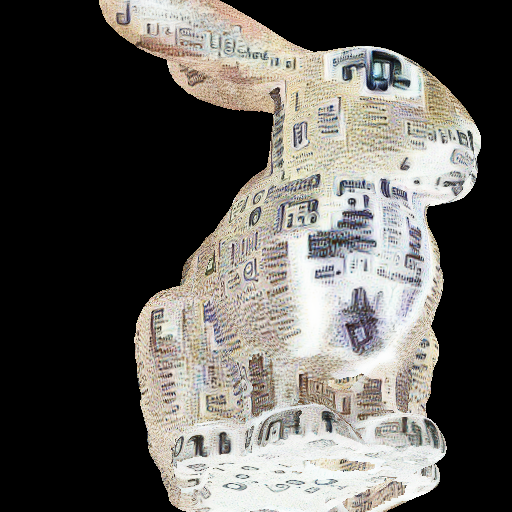
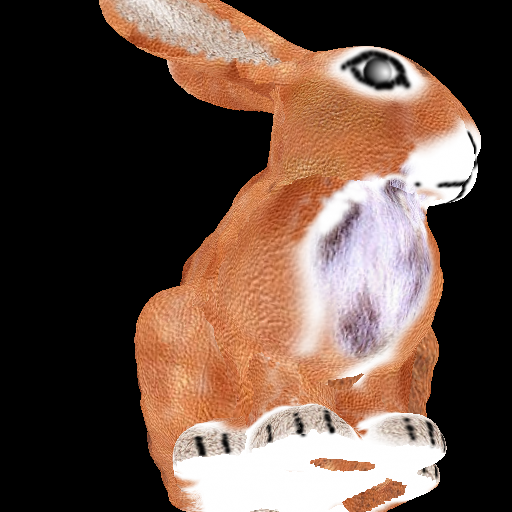

400 [1001.3007, 1889.8368]


In [18]:
run(mesh)

Since this is such a stochastic optimization procedure, it's good to sanity check that we observe the loss going down.

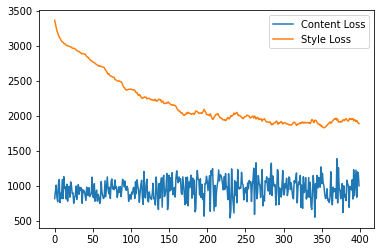

In [19]:
pl.plot(loss_log);
pl.legend(['Content Loss', 'Style Loss'])
pl.show()

# **Display Result**
For the models with less complex textures—i.e. all except the bunny model—the content objective can be subtle. For example, in the case of the skull, its easiest to observe that the content loss is effective when viewing the cranial sutures. You can click and drag the output of the next cell to view the sides and top of the skull model.


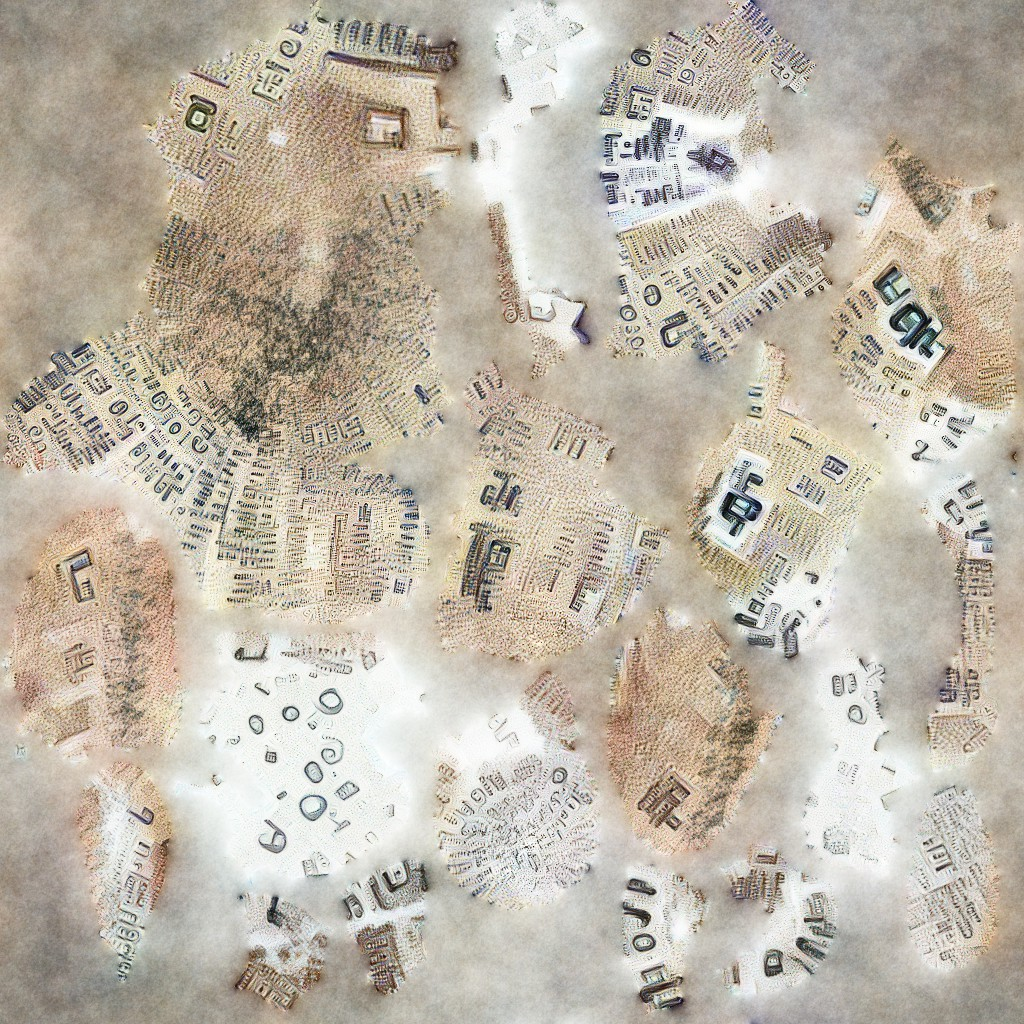

In [20]:
texture = t_texture.eval()
show.textured_mesh(mesh, texture)

You can also view the texture we optimized directly:


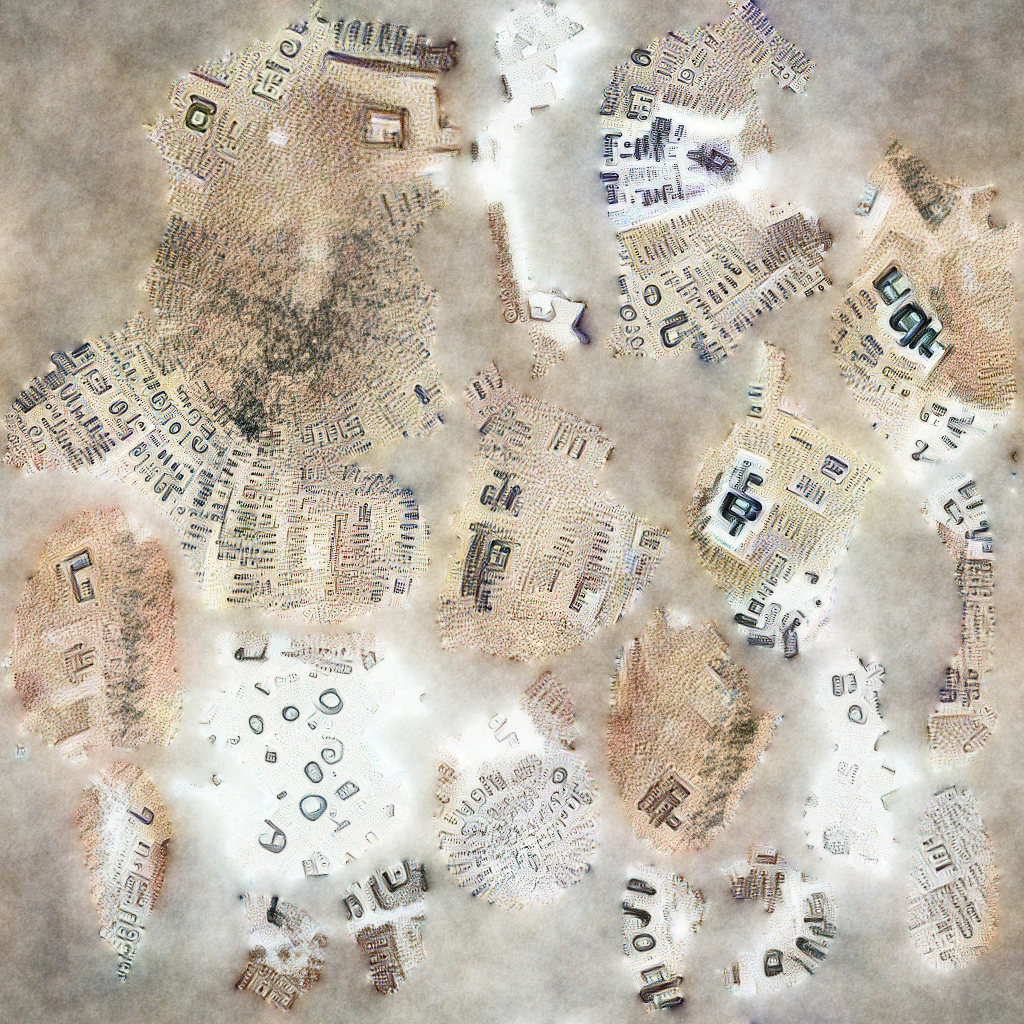

In [21]:
show.image(texture, 'jpeg')

# **Renderer**
We provide a way to sample random views onto a 3D model. You can specify the range of distances, and the resulting views will be centered on the object. The resulting 4x4 matrix is interpreted as a ModelView matrix.

Let's initialize a renderer and take a look on our mesh from the direction of random_view.


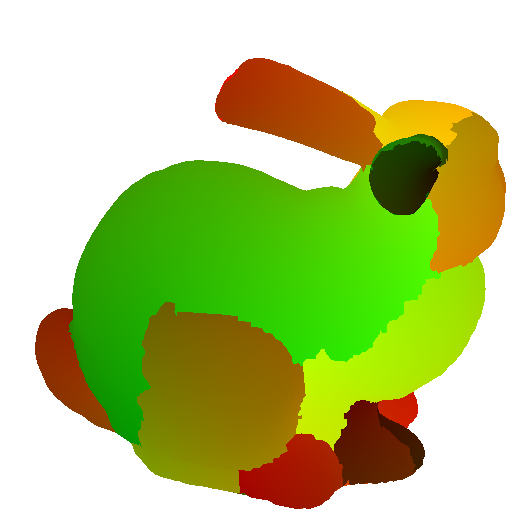

In [22]:
random_view = meshutil.sample_view(11.0, 13.0,)

random_view_image = renderer.render_mesh(modelview=random_view, **mesh)
show.image(random_view_image)


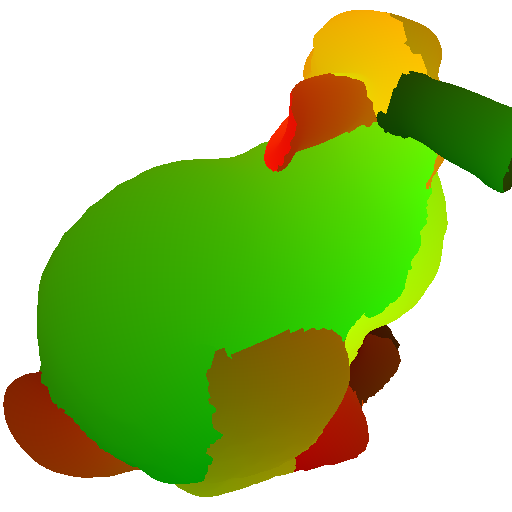
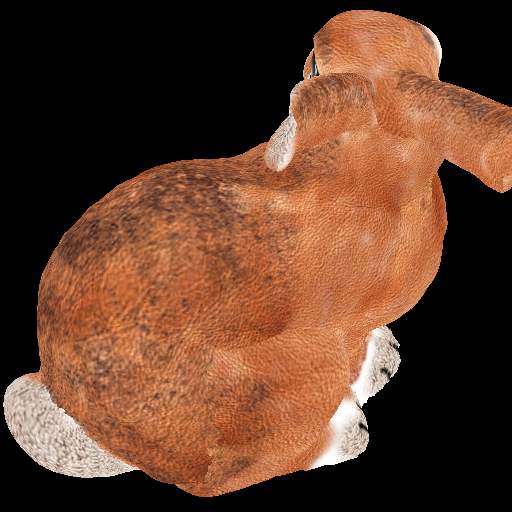

In [23]:
t_frame = sample_bilinear(t_texture, t_uv) * t_alpha


fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 13.0), **mesh)
img = t_frame.eval({t_fragments: fragments, t_texture: original_texture})
show.images([fragments, img])